In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from google.colab import drive

In [3]:
# Mount Google Drive
drive.mount('/content/drive')
# Load the data
df = pd.read_csv('/content/drive/MyDrive/postings.csv')

# Basic Overview
overview = {
    "Total Entries": df.shape[0],
    "Unique Job Titles": df['job_title'].nunique(),
    "Unique Companies": df['company'].nunique(),
    "Unique Locations": df['job_location'].nunique()
}

# Missing Values
missing_values = df.isnull().sum()

# Top 10 Job Titles
top_job_titles = df['job_title'].value_counts().head(10)

# Top 10 Companies
top_companies = df['company'].value_counts().head(10)

# Top 10 Locations
top_locations = df['job_location'].value_counts().head(10)

# Skills Analysis
df['job_skills'] = df['job_skills'].fillna('')  # Replace NaN with empty string
skills_list = df['job_skills'].str.lower().str.split(',').explode().str.strip()
top_skills = skills_list.value_counts().head(10)

# Creating DataFrames for better display
overview_df = pd.DataFrame(list(overview.items()), columns=['Category', 'Count'])
missing_values_df = pd.DataFrame(missing_values, columns=['Missing Values'])
top_job_titles_df = pd.DataFrame(top_job_titles).reset_index().rename(columns={'index': 'Job Title', 'job_title': 'Frequency'})
top_companies_df = pd.DataFrame(top_companies).reset_index().rename(columns={'index': 'Company', 'company': 'Frequency'})
top_locations_df = pd.DataFrame(top_locations).reset_index().rename(columns={'index': 'Location', 'job_location': 'Frequency'})
top_skills_df = pd.DataFrame(top_skills).reset_index().rename(columns={'index': 'Skill', 'job_skills': 'Frequency'})

# Print the results
print("Overview of Dataset:")
print(overview_df)
print("\nMissing Values in Dataset:")
print(missing_values_df)
print("\nTop 10 Job Titles:")
print(top_job_titles_df)
print("\nTop 10 Companies:")
print(top_companies_df)
print("\nTop 10 Locations:")
print(top_locations_df)
print("\nTop 10 Skills:")
print(top_skills_df)


Mounted at /content/drive
Overview of Dataset:
            Category  Count
0      Total Entries   6025
1  Unique Job Titles   2566
2   Unique Companies   2565
3   Unique Locations   1296

Missing Values in Dataset:
                Missing Values
job_title                    0
company                      0
job_location                 0
job_link                     0
first_seen                   0
search_city                  0
search_country               0
job level                    0
job_type                     0
job_summary                360
job_skills                1065

Top 10 Job Titles:
                              Frequency  count
0                  Senior Data Engineer    537
1                         Data Engineer    449
2                          Data Analyst    187
3         Senior Staff AI Data Engineer    150
4  Senior Data Engineer, Public Company    119
5                   Senior Data Analyst    103
6                   Staff Data Engineer     97
7                

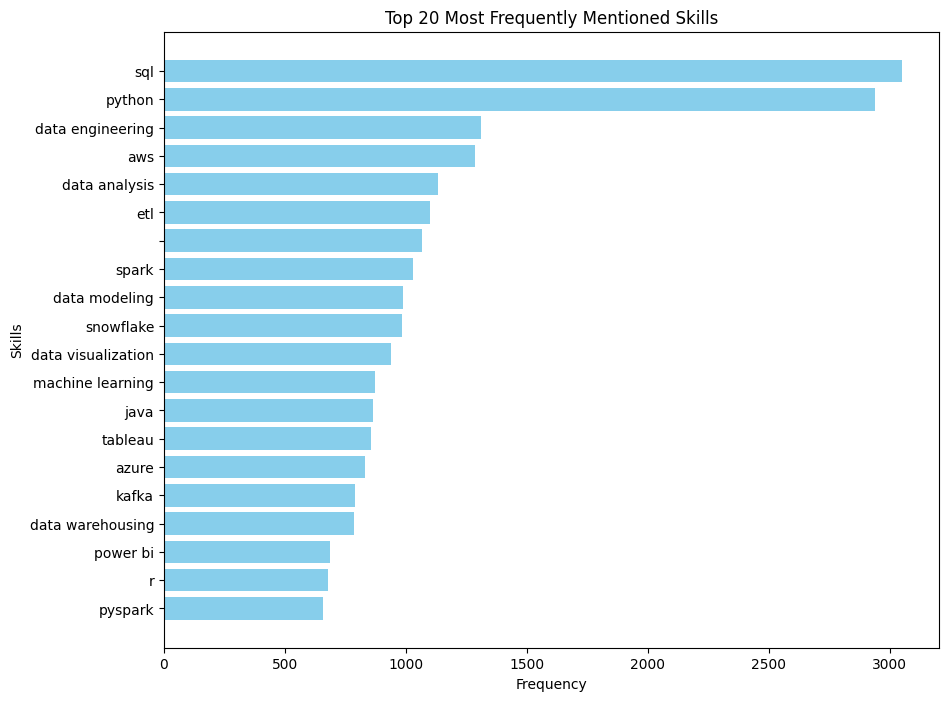

In [4]:
# Handle missing values and split the skills
df['job_skills'] = df['job_skills'].fillna('')  # Replace NaN with empty string
skills_list = df['job_skills'].str.lower().str.split(',').explode().str.strip()

# Count the frequency of each skill
skill_counts = Counter(skills_list)

# Plot top 20 most frequent skills
top_skills = dict(skill_counts.most_common(20))
plt.figure(figsize=(10, 8))
plt.barh(list(top_skills.keys()), list(top_skills.values()), color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Skills')
plt.title('Top 20 Most Frequently Mentioned Skills')
plt.gca().invert_yaxis()  # Invert y-axis to show the most frequent skills at the top
plt.show()

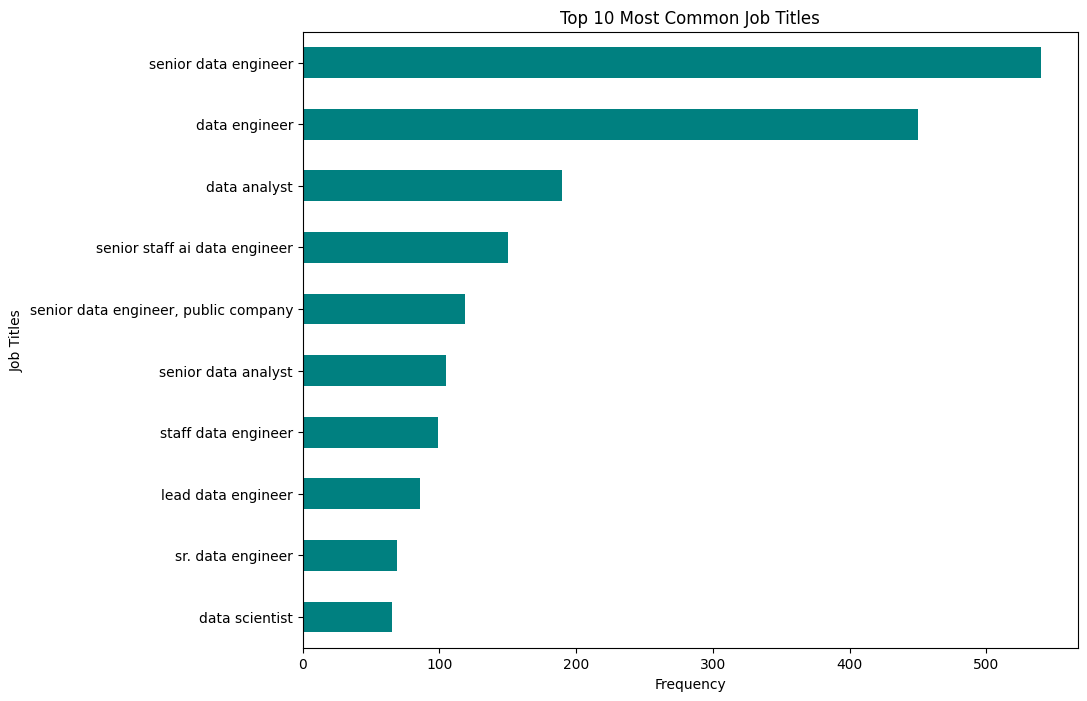

In [5]:
# Count the frequency of each job title
job_title_counts = df['job_title'].str.lower().value_counts().head(10)

# Plot the top 10 job titles
plt.figure(figsize=(10, 8))
job_title_counts.plot(kind='barh', color='teal')
plt.xlabel('Frequency')
plt.ylabel('Job Titles')
plt.title('Top 10 Most Common Job Titles')
plt.gca().invert_yaxis()  # Invert y-axis to show the most common titles at the top
plt.show()

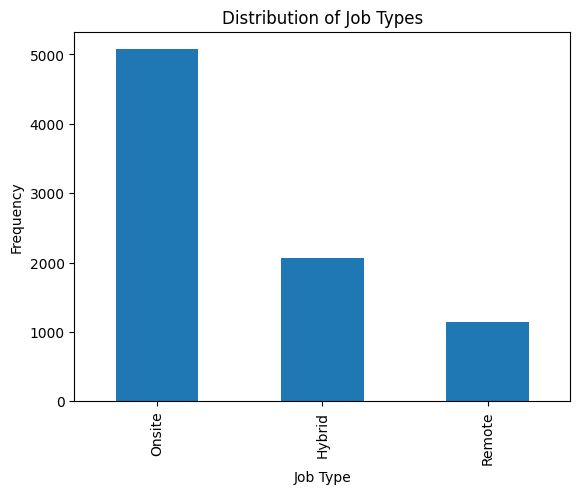

In [7]:
job_level_counts = df['job level'].value_counts()
job_type_counts = df['job_type'].value_counts()

# For Job Levels
job_level_counts.plot(kind='bar', title='Distribution of Job Levels')
plt.xlabel('Job Level')
plt.ylabel('Frequency')

# For Job Types
job_type_counts.plot(kind='bar', title='Distribution of Job Types')
plt.xlabel('Job Type')
plt.ylabel('Frequency')
plt.show()

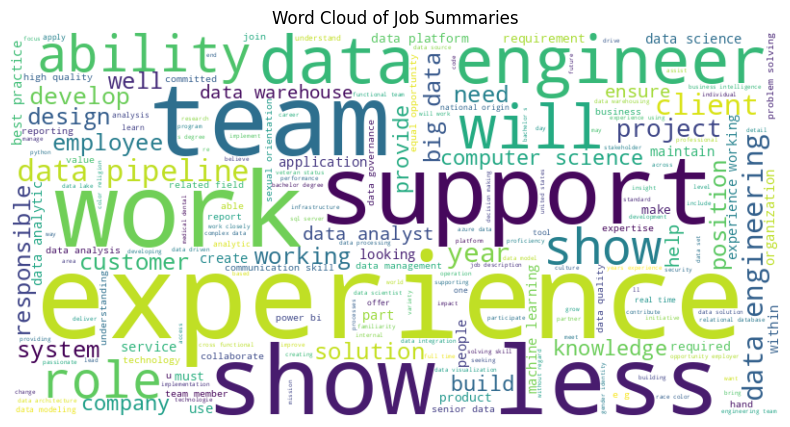

In [6]:
from wordcloud import WordCloud

# Combine all job summaries into one large text
text = ' '.join(df['job_summary'].dropna().str.lower())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Job Summaries')
plt.show()


In [9]:
# Ensure necessary NLTK downloads
nltk.download('stopwords')
nltk.download('wordnet')

# Load data
file_path = '/content/drive/MyDrive/postings.csv'
df = pd.read_csv(file_path)

# Function to preprocess text
def preprocess_text(text):
    # Convert to lower case
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply preprocessing to the combined text data
df['text_data'] = df['job_title'].fillna('') + " " + df['job_skills'].fillna('')
df['text_data'] = df['text_data'].apply(preprocess_text)

# TF-IDF Vectorization with n-grams
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=2, max_df=0.85, max_features=10000)
tfidf_matrix = tfidf.fit_transform(df['text_data'])

# Calculate Cosine Similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Recommendation function
def recommend_jobs(job_index, num_recommendations=5):
    sim_scores = list(enumerate(cosine_sim[job_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations + 1]  # Skip the first one as it is the job itself
    job_indices = [i[0] for i in sim_scores]
    return df.iloc[job_indices][['job_title', 'company', 'job_summary']]

# Example usage: Recommend jobs similar to the job at index 10
recommended_jobs = recommend_jobs(10, 5)
print(recommended_jobs)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                        job_title  \
2126                        Data Quality Engineer   
1542                          Data Engineer - ETL   
5009  Business Intelligence Data Quality Engineer   
3752                            ETL Data Engineer   
4794                  Senior Data Engineer-Canada   

                                    company  \
2126                    Knights of Columbus   
1542       Liberty Personnel Services, Inc.   
5009  Maxor National Pharmacy Services, LLC   
3752                                HCLTech   
4794                      Zortech Solutions   

                                            job_summary  
2126                                                NaN  
1542  Job Details:\nData Engineer - ETL\nLocal Candi...  
5009  Overview\nMaxor is seeking an experienced, rem...  
3752                                                NaN  
4794  Role: Senior Data Engineer\nLocation: Vancouve...  
